# Exploration of US healthcare spend -- Data cleaning

###   
## Data Sources:

### 1. Inpatient charge data

Source: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Inpatient2017

This data set provides the charges and payments of healthcare procedures for the years 2011-2017 for more than 3,000 U.S. hospitals.  Charges are for 100 common diagnoses in years 2011-2013 and for 560+ common diagnoses for years 2014-2017.  Each year consisted of 160k-200k rows of data.

### 2. United States Senate Lobby Disclosure Act reports

Source: https://www.senate.gov/legislative/Public_Disclosure/LDA_reports.htm

This data set was collected from the US Senate Lobby Disclosure Act (LDA) database.  The LDA database was queried on 'Health Issues' and 'Mediare/Medicaid issues' for each individual US state.  Data is for years 1999 - 2019 for each US state and is based on the clients' home state (and not lobbyists state). Data for each state ranges from 1000 to 13,000 entries.  DC is not included.

### 3. United States census data

Source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

Provides population of 50 states from the 2010 census.


### Data limitations and assumptions

Although there is a lot of data on healthcare charges/payments as well as lobbying data, this data is far from complete and there are limitations and assumptions being made.

Regarding hospital inpatient charge data:
- Data is for 50 United States and does not include Washington DC or other US Territories.
- Data is for over 3,000 hospitals which accept Medicare payments, which do not represent all hospitals in the US.  To date, there are over 5,500 registered hospitals and care facilities in the US.
- Data is for common diagnoses as it pertains to Medicare, the federal insurance plan largely for elderly and disabled citizens.  These diagnoses may not reflect common diagnoses for the US population as a whole.
- The amount paid by all includes Medicare payments, it is unknown what percentage of total payments is attributed to Medicare.

Regarding US Senate Lobby Disclosure Act data:
- Senate LDA reports are for the US Senate only.  Similar LDA reports exist for the US House of Representatives, but the lobbying activity on the House-level is relatively small as compared to the Senate-level, and therefore not included. 
- LDA reports are collected based on the 'Health Issues' and 'Medicare/Medicaid' categories and do not include 'Medical Research' or 'Pharmaceuticals' categories.
- LDA reports are collected based on the home state of the client making the lobbying request (and not the lobbyist itself). Although many clients represent health organizations within their home state, many represent national associations outside of their home state as well.
- Lobbying is often not directed to the client's state senators, but to the Senate Committee involved with health or Medicare issues.
- Reported lobbying may not be entirely dedicated to health or Medicare issues, but rather distributed across many issues.  The LDA report allows lobbying to be directed to multiple issues, of which health and Medicare were selected as two of many categories.
- Not all lobbying funds are reported.  Activities of less than 5,000 do not have to be reported.
- Not all clients are directly involved with healthcare or hospital facilities. Some are publicly traded corporations and manufacturers, (Ex: Walmart in Arkansas).
- Not all clients are represented by their client state.  Many clients appear to have offices in the VA / DC areas, presumably to be close to lobbyists. DC (and comparatively VA too) is vastly overrepresented due to many clients have having offices in DC.  As a result, DC is not included in this exploration.

### Import tools 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ipywidgets as widget
import string

##  
## 1. Clean inpatient charge data

In [2]:
# Import annual healtchare cost data into a costs dictionary 'c', each dtaframe is keyed for each year

c={}
my_years1 = [2011, 2012, 2013, 2014, 2015, 2016, 2017]
for yr in my_years1:
    c[yr] = pd.read_csv(f'./data/yearly_costs/costs_{yr}.csv')

In [3]:
c[2017].head(2)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,023 - CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACU...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,28,117117.79,25823.71,24057.39
1,025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL P...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,32,98357.56,20688.34,19791.41


In [4]:
# CLEAN cost data, for every df/ year in my costs dictionary ...

for yr in my_years1:
    # change COL names, annotate the years
    c[yr].columns = ['diagnosis', 'id', 'name','address','city','state','zip','region',
       f'patients_{yr}', f'charged_{yr}', f'paid_byall_{yr}', f'paid_bymed_{yr}']
    
    # drop COLS I won't be using
    c[yr].drop(columns = ['id', 'name', 'address', 'city', 'zip', 'region'],inplace= True)
    
    # truncate Diagnosis Related Group (DRG) description to 3 digit string
    c[yr].diagnosis = c[yr].diagnosis.str[0:3]
    
    # drop DC as a state
    c[yr].drop(c[yr][c[yr]['state'] == 'DC'].index, inplace=True)    
 
    # consolidate all the state data by diagnosis, and get the median of what each state charges/ is paid
    c[yr]=c[yr].groupby(['state','diagnosis'],as_index=False).median()


    # NEW COL = this col compares the cost of a procedure vs what medicare pays
    c[yr][f'charge_over_med_{yr}'] = (c[yr][f'charged_{yr}'] - c[yr][f'paid_bymed_{yr}']
                                     ) / c[yr][f'paid_bymed_{yr}']

    # NEW COL = this col compares the average amount paid for a procedure vs what medicare pays
    c[yr][f'paid_over_med_{yr}'] = (c[yr][f'paid_byall_{yr}'] - c[yr][f'paid_bymed_{yr}']
                                     ) / c[yr][f'paid_bymed_{yr}']             
    
    # mark the progress
    print(f'YR={yr}, SHAPE={c[yr].shape}, STATES={len(c[yr].state.unique())},  DIAGNOSES={len(c[yr].diagnosis.unique())}')
    
print('Summy of dictionary with yearly healthcare charge and payment data')

YR=2011, SHAPE=(4925, 8), STATES=50,  DIAGNOSES=100
YR=2012, SHAPE=(4939, 8), STATES=50,  DIAGNOSES=100
YR=2013, SHAPE=(4937, 8), STATES=50,  DIAGNOSES=100
YR=2014, SHAPE=(14809, 8), STATES=50,  DIAGNOSES=564
YR=2015, SHAPE=(15024, 8), STATES=50,  DIAGNOSES=563
YR=2016, SHAPE=(15239, 8), STATES=50,  DIAGNOSES=573
YR=2017, SHAPE=(15223, 8), STATES=50,  DIAGNOSES=563
Summy of dictionary with yearly healthcare charge and payment data


In [5]:
# MERGE all the years into one dataframe
# Data is merged on the State and the (DRG) diagnosis, mark our progress

merge1 = c[2011].merge(c[2012], on=['state','diagnosis'])
print(merge1.shape)

merge2 = merge1.merge(c[2013], on=['state','diagnosis'])
print(merge2.shape)

merge3 = merge2.merge(c[2014], on=['state','diagnosis'])
print(merge3.shape)

merge4 = merge3.merge(c[2015], on=['state','diagnosis'])
print(merge4.shape)

merge5 = merge4.merge(c[2016], on=['state','diagnosis'])
print(merge5.shape)

merge6 = merge5.merge(c[2017], on=['state','diagnosis'])
print(merge6.shape)


(4819, 14)
(4659, 20)
(4641, 26)
(4582, 32)
(4494, 38)
(4468, 44)


In [6]:
# LOOK at data
merge6.head(2)

,state,diagnosis,patients_2011,charged_2011,paid_byall_2011,paid_bymed_2011,charge_over_med_2011,paid_over_med_2011,patients_2012,charged_2012,...,paid_byall_2016,paid_bymed_2016,charge_over_med_2016,paid_over_med_2016,patients_2017,charged_2017,paid_byall_2017,paid_bymed_2017,charge_over_med_2017,paid_over_med_2017
0,AK,039,23.0,34805.13,8401.95,6413.780,4.426617,0.309984,41.0,37220.290,...,9939.755,7997.96,6.392435,0.242786,17.0,57731.59,11848.420,8924.59,5.468823,0.327615
1,AK,064,22.5,42453.81,21608.01,20555.255,1.065351,0.051216,23.0,63529.835,...,20347.880,14427.33,4.285786,0.410370,23.5,91303.77,19342.045,17997.88,4.073029,0.074685


In [7]:
# CREATE a list of  US states and list of diagnoses common to all 50 states and all 7 years of data

my_states = (np.unique(merge6.state))
common_diagnoses=(np.unique(merge6.diagnosis))

len(common_diagnoses), len(my_states)

# We have 93 diagnoses common to all 50 states and 7 years in our data.

(93, 50)

In [8]:
# TRANSFORM our data to resemble time series

# create new COL representing BOTH STATE and diagnosis
merge6['STdiag']=merge6.state+merge6.diagnosis

# drop old COLS and make new COL the index
merge6.drop(columns = ['state', 'diagnosis'],inplace= True)
merge6 = merge6.set_index('STdiag')

# Transpose so data resembles a time series
# c_data = cost data
c_data = merge6.T
c_data = c_data.reset_index()
c_data.rename(columns = {'index':'year'}, inplace = True)


# We will use the following columns for advanced EDA going forward

# Create a NEW COL for the median for all US states and all procedures
c_data['USall'] = c_data.median(axis=1)

# Create new COLS for STATE median for all 93 diagnoses
for st in my_states:
    c_data[f'{st}_alld']= c_data.filter(like = st).median(axis=1)

# Create new COLS for DIAGNOSIS median for all states
for di in common_diagnoses:
    c_data[f'{di}_alls']= c_data.filter(like= di).median(axis=1)    
    
c_data.head()

STdiag,year,AK039,AK064,AK065,AK066,AK101,AK176,AK177,AK189,AK190,...,812_alls,853_alls,870_alls,871_alls,872_alls,885_alls,897_alls,917_alls,918_alls,948_alls
0,patients_2011,23.000000,22.500000,17.500000,18.000000,19.500000,26.00000,14.500000,18.000000,21.000000,...,27.500000,23.50000,18.000000,66.000000,33.500000,97.000000,21.000000,17.000000,18.000000,21.00000
1,charged_2011,34805.130000,42453.810000,32821.000000,25238.105000,23156.085000,35672.65000,61224.635000,46478.270000,38283.970000,...,15453.660000,109708.32500,127612.695000,33980.337500,21764.870000,15811.635000,13784.107500,30302.720000,13517.330000,14452.81000
2,paid_byall_2011,8401.950000,21608.010000,12437.045000,9320.250000,7682.735000,10349.50000,16333.210000,12566.070000,13617.720000,...,4974.510000,36500.27500,39247.940000,12235.187500,7223.357500,6229.850000,4363.870000,10034.565000,4037.550000,4396.05000
3,paid_bymed_2011,6413.780000,20555.255000,10495.340000,8372.925000,5942.060000,7460.65000,15395.450000,11521.070000,12691.540000,...,4086.900000,33812.40000,36628.660000,11018.880000,6161.610000,5259.040000,3347.610000,8783.230000,3136.640000,3449.40500
4,charge_over_med_2011,4.426617,1.065351,2.127197,2.014252,2.896979,3.78144,2.976801,3.034197,2.016495,...,2.581216,1.96573,2.437502,2.011371,2.423447,2.049432,3.194144,2.448256,3.384101,3.01476


In [9]:
# SAVE the cleaned cost data

c_data.to_csv('./data/cleaned/cost_data.csv', index=False)

##   
## 2. High level exploration of inpatient charge data

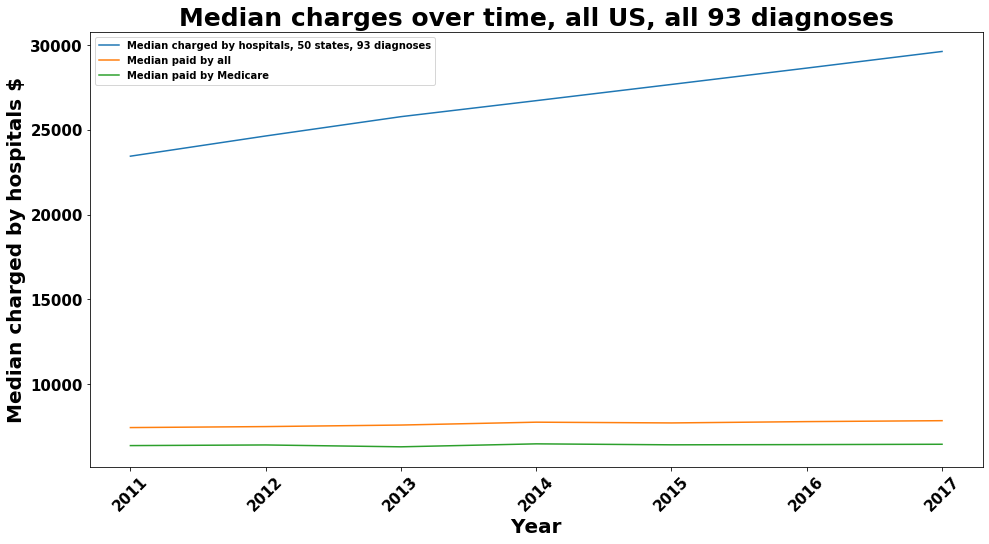

In [10]:
# PLOT US healthcare charges/payments over time, 50 states, 93 diagnoses

y1 = c_data[c_data.year.str.contains("charged")]['USall']
y2 = c_data[c_data.year.str.contains("byall")]['USall']
y3 = c_data[c_data.year.str.contains("bymed")]['USall']

plt.figure(figsize=(16,8))
plt.title('Median charges over time, all US, all 93 diagnoses', fontsize = 25)
plt.plot(my_years1, y1, label = 'Median charged by hospitals, 50 states, 93 diagnoses')
plt.plot(my_years1, y2, label = 'Median paid by all')
plt.plot(my_years1, y3, label = 'Median paid by Medicare')
plt.xlabel('Year',fontsize=20)
plt.ylabel('Median charged by hospitals $',fontsize=20)
plt.xticks(my_years1,fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.legend(loc='best');


In [11]:
# INTERACTIVE PLOT to explore costs/ payments in each state.

# FUNCTION
def my_statecost1(state1):
    
    y1 = c_data[c_data.year.str.contains("charged")][f'{state1}_alld']    
    y2 = c_data[c_data.year.str.contains("byall")][f'{state1}_alld']
    y3 = c_data[c_data.year.str.contains("bymed")][f'{state1}_alld']
    
    plt.figure(figsize=(16,8))
    plt.title(f'Hospital payments in {state1}, median of 93 diagnoses', fontsize=25)
    #plt.plot(my_years1, y1,label = 'Median charge for diagnoses')
    plt.plot(my_years1, y2, label = 'Median payment by all')
    plt.plot(my_years1, y3, label = 'Median payment by Medicare')
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Charged by/ Paid to hospitals($)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylim(5_000,15_000)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');

# WIDGET
state_slider1 = widget.SelectionSlider(
    options=my_states,
    value='AK',
    description='State:',
    orientation='horizontal')

# INTERACT widget with function
widget.interact(my_statecost1 , state1=state_slider1)        

interactive(children=(SelectionSlider(description='State:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT',…

<function __main__.my_statecost1(state1)>

In [12]:
# INTERACTIVE PLOT to explore costs / payments by diagnosis

#FUNCTION
def my_statecost2(state2,diag1):
    
    y1 = c_data[c_data.year.str.contains("charged")][f'{state2}{diag1}']
    y2 = c_data[c_data.year.str.contains("byall")][f'{state2}{diag1}']
    y3 = c_data[c_data.year.str.contains("bymed")][f'{state2}{diag1}']

    plt.figure(figsize=(16,8))
    plt.title(f'How much hospitals in {state2} charge / get paid for diagnosis {diag1}', fontsize=25)    
    plt.plot(my_years1, y1, label = 'Median charged by hospital ')
    plt.plot(my_years1, y2, label = 'Median payment by all')
    plt.plot(my_years1, y3, label = 'Median payment by Medicare')  
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Charged by/ paid to hospitals($)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');

# WIDGETS
state_slider2 = widget.SelectionSlider(
    options=my_states,
    value='CO',
    description='State:',
    orientation='horizontal' )
diagnosis_slider = widget.SelectionSlider(
    options=common_diagnoses,
    value='039',
    description='Diagnosis code:',
    orientation='horizontal'  )
widget.interact(my_statecost2, state2=state_slider2, diag1=diagnosis_slider)        

interactive(children=(SelectionSlider(description='State:', index=5, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'C…

<function __main__.my_statecost2(state2, diag1)>

In [13]:
# INTERACTIVE PLOT to compare 2 US states

# FUNCTION
def my_statcosts3(state3,state4):
    # one US state
    y1 = c_data[c_data.year.str.contains("charged")][f'{state3}_alld']
    y2 = c_data[c_data.year.str.contains("byall")][f'{state3}_alld']
    y3 = c_data[c_data.year.str.contains("bymed")][f'{state3}_alld']
    # other US state
    y4 = c_data[c_data.year.str.contains("charged")][f'{state4}_alld']
    y5 = c_data[c_data.year.str.contains("byall")][f'{state4}_alld']
    y6 = c_data[c_data.year.str.contains("bymed")][f'{state4}_alld']    
    
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing hospital charges and payments in {state3} and {state4} (93 diagnoses)', fontsize=25)   
    plt.plot(my_years1, y1,
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state3} Median charge for diagnosis')
    plt.plot(my_years1, y2,
             color = 'green',
             linestyle = 'dashed',
             marker = '^',
             label = f'{state3} Median payment by all')
    plt.plot(my_years1, y3,
             color = 'darkgreen',
             linestyle = 'solid',
             marker = 's',
             label = f'{state3} Median payment by Medicare')
    
    plt.plot(my_years1, y4,
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',             
             label = f'{state4} Median charge for diagnosis')
    plt.plot(my_years1, y5,
             color = 'red',
             linestyle = 'dashed',
             marker = '^',
             label = f'{state4} Median payment by all')
    plt.plot(my_years1, y6,
             color = 'darkred',
             linestyle = 'solid',
             marker = 's',
             label = f'{state4} Median payment by Medicare')     
                                                                                                                            
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Charged by/ paid to hospitals',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');

# WIDGETS
state_select3 = widget.Select(
    options=my_states,
    value='AL',
    description='State1:'  )
    
state_select4 = widget.Select(
    options=my_states,
    value='CT',
    description='State2:'  )    

widget.interact(my_statcosts3, state3=state_select3, state4= state_select4)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statcosts3(state3, state4)>

##    
## 3. Clean the lobbying data

### Read in US population data, from 2010 Census

In [14]:
# READ in data
pop=pd.read_csv('./data/population.csv')
pop.head(2)
# No additional cleaning needed

,state,population
0,AL,4779736
1,AK,710231


### Read in and clean Lobby Disclosure Act (LDA) reports for 'Health Issues' and 'Medicare/Medicaid'

In [15]:
# READ lobby reports for 'Health Issues' into health Lobby (hl) dictionary
# each dataframe keyed for each state
hl={}
for st in my_states:
    hl[st] = pd.read_csv(f'./data/healthissue_lobby/{st}.csv')
    
hl['AL'].head(2)

,State,Registrant Name,Client Name,Filing Type,Amount Reported,Date Posted,Filing Year
0,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FOURTH QUARTER REPORT,"$10,000.00",1/17/2020,2019
1,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FOURTH QUARTER REPORT,"$15,000.00",1/30/2019,2018


In [16]:
# READ LDA reports for 'Medicare' issues into medicare lobby (ml)dictionary 
# each dataframe keyed for each state
ml={}
for st in my_states:
    ml[st] = pd.read_csv(f'./data/medicare_lobby/{st}_med.csv')
    
ml['AL'].head(2)

,State,Registrant Name,Client Name,Filing Type,Amount Reported,Date Posted,Filing Year
0,AL,"R.G. FLIPPO AND ASSOCIATES, INC",ALABAMA NURSING HOME ASSOCIATION,MID-YEAR REPORT,"40,000.00",8/6/1999,1999
1,AL,Ben Barnes Group LP,TORCHMARK CORP,REGISTRATION,NaN,10/15/1999,1999


In [17]:
# COMBINE / APPEND the two sets of lobby data into one dictionary for (s) states
s = {}
for st in my_states:
    s[st] = hl[st].append(ml[st], ignore_index = True)
    
s['AL'].head()

,State,Registrant Name,Client Name,Filing Type,Amount Reported,Date Posted,Filing Year
0,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FOURTH QUARTER REPORT,"$10,000.00",1/17/2020,2019
1,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FOURTH QUARTER REPORT,"$15,000.00",1/30/2019,2018
2,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FIRST QUARTER REPORT,"$15,000.00",4/17/2019,2019
3,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,SECOND QUARTER REPORT,"$15,000.00",7/18/2019,2019
4,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,THIRD QUARTER AMENDMENT,"$15,000.00",10/23/2018,2018


In [18]:
# CLEAN the Lobby data ... for each state in the dictionary...

for st in my_states:
    # CHANGE the col names
    s[st].columns = ['state', 'lobbyist', 'client','report','amount','date','year']
    
    # Because we merged Medicare and Health Issue lobbies, we many have duplicate reports
    # DELETE duplicates
    s[st] = s[st].drop_duplicates()
    
    # SORT on datetime
    #s[st]['date'] = pd.to_datetime(s[st]['date'])
    s[st].sort_values(by=['date'], inplace = True)
    
    # If there is an AMENDMENT report, keep the latest AMENDMENT and discard the previous REPORT
    # CREATE new COL 'period' by splitting the 'report' COL ex: [THIRD, QUARTER]
    s[st]['period'] = (s[st]['report'].str.split().str[:-1])
    # new COL has to be joined to form one string
    s[st]['period'] = s[st]['period'].map(lambda val: ' '.join(val))
    # REMOVE duplicates based on the following columns
    s[st] = s[st].drop_duplicates(subset = ['state','client', 'year', 'period'],keep = 'last')    
        
    # REMOVE all the nuls, removes all 'REGISTRATION', 'TERMINATION', other reports with no reported amounts
    s[st].dropna(inplace=True)    

    # DROP cols I won't be using
    s[st].drop(columns = ['lobbyist', 'date','period'],inplace= True)

    # CONVERT currency to float
    s[st].amount = s[st].amount.astype(str)
    s[st].amount = s[st].amount.str.replace('$','')
    s[st].amount = s[st].amount.str.replace(',','')
    s[st].amount = s[st].amount.str.replace(' ','')
    s[st].amount = s[st].amount.astype(float)    
 
    # GROUP by the year and sum up all the lobbying for the year, per state
    s[st]=s[st].groupby(['year'],as_index=False).sum()

    # NEW COL divide sum amount by population for per capita
    s[st]['per_cap']= s[st].amount/ (pop[pop.state == st]['population'].values[0] ) 
    s[st].rename(columns = {'amount': f'{st}amount', 'per_cap' : f'{st}per_cap'}, inplace=True)
    
s['AL'].head()

,year,ALamount,ALper_cap
0,1999,360000.0,0.075318
1,2000,500000.0,0.104608
2,2001,600000.0,0.125530
3,2002,1320000.0,0.276166
4,2003,1370000.0,0.286627


In [19]:
# Many of the US states do not have any registered lobbying $ activities for certain years.
# ASSIGN $0 to these missing years

my_years2 = list(range(1999,2020))

for st in my_states:
    for yr in my_years2:
        if yr not in s[st].year.unique():
            s[st] = s[st].append(pd.Series([yr,0,0], index=s[st].columns ),ignore_index=True)
    s[st].sort_values(by=['year'], inplace = True)   

In [20]:
# MERGE lobbying dictionaries into one lobby_data dataframe (l_data)

l_data = s['AK'].merge(s['AL'], on=['year'])
for i in range(2,50):
    temp_data = l_data.merge(s[my_states[i]], on = ['year'])
    l_data = temp_data

# CREATE COLS for national data
l_data['US_total$lobbied'] = l_data.filter(like = 'amount').sum(axis = 1)
l_data['US_median$bystate'] = l_data.filter(like= 'amount').median(axis=1) 
l_data['US_median$percap'] = l_data.filter(like= 'per_cap').median(axis=1)

l_data.head(2)

,year,AKamount,AKper_cap,ALamount,ALper_cap,ARamount,ARper_cap,AZamount,AZper_cap,CAamount,...,WAper_cap,WIamount,WIper_cap,WVamount,WVper_cap,WYamount,WYper_cap,US_total$lobbied,US_median$bystate,US_median$percap
0,1999,0.0,0.00000,360000.0,0.075318,380000.0,0.130319,855000.0,0.133761,10597700.0,...,0.212850,1212700.0,0.213241,70000.0,0.037777,0.0,0.0,137272630.0,638000.0,0.137462
1,2000,40000.0,0.05632,500000.0,0.104608,1310000.0,0.449258,200000.0,0.031289,11241400.0,...,0.370388,932734.0,0.164012,130000.0,0.070157,0.0,0.0,160337119.0,906367.0,0.183723


In [21]:
# SAVE the CLEANED lobby data

l_data.to_csv('./data/cleaned/lobby_data.csv', index=False)

##   
## 4. High level exploration of lobby data

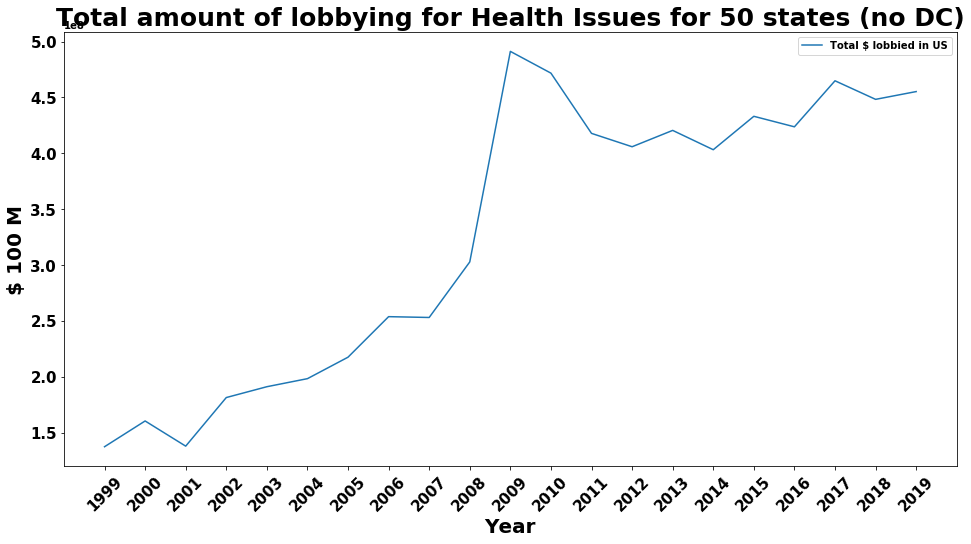

In [22]:
# PLOT total amount of lobbying for Health Issues for 50 states (no DC)

plt.figure(figsize=(16,8))
plt.title('Total amount of lobbying for Health Issues for 50 states (no DC)', fontsize = 25)
plt.plot(l_data.year,l_data['US_total$lobbied'], label = 'Total $ lobbied in US')
plt.xlabel('Year',fontsize=20)
plt.ylabel('$ 100 M',fontsize=20)
plt.xticks(l_data.year,fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.legend(loc='best');

# Comment - big spike in 2009 and 2010 probably due to reaction to Obamacare

In [23]:
# INTERACTIVE PLOT - compare total healthcare lobbying between two states

def my_statelobby1(state5,state6):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing healthcare lobbying for {state5} and {state6} (US Senate)', fontsize=25)
    plt.plot(l_data.year, l_data[f'{state5}amount'],
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state5} total lobbying')

    plt.plot(l_data.year, l_data[f'{state6}amount'],
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state6} total lobbying')
                                          
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to lobbyists ($10M)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select5 = widget.Select(
    options=my_states,
    value='AL',
    description='State1:',
    )
    
state_select6 = widget.Select(
    options=my_states,
    value='CT',
    description='State2:',
    )    

widget.interact(my_statelobby1, state5=state_select5, state6= state_select6)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statelobby1(state5, state6)>

In [24]:
# INTERACTIVE PLOT - cmpare lobbying per capita for two states

#FUNCTION
def my_statelobby2(state7,state8):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing healthcare lobbying per capita for {state7} and {state8} (US Senate)', fontsize=25)
 
    plt.plot(l_data.year, l_data[f'{state7}per_cap'],
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state7} per capita lobbying')

    plt.plot(l_data.year, l_data[f'{state8}per_cap'],
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state8} per capita lobbying')
                                          
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to lobbyists ($ percapita)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
# WIDGETS
state_select7 = widget.Select(
    options=my_states,
    value='AL',
    description='State1:')
state_select8 = widget.Select(
    options=my_states,
    value='CT',
    description='State2:')    
widget.interact(my_statelobby2, state7=state_select7, state8= state_select8)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statelobby2(state7, state8)>

##  
## End of Data notebook, please continue with EDA notebook